In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk(r'C:\dataset\C-NMC_Leukemia'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\10.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\100.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1000.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1001.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1002.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1003.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1004.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1005.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1006.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1007.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1008.bmp
C:\dataset\C-NMC_Leukemia\testing_data\C-NMC_test_final_phase_data\1009.bmp
C:\dataset\C-NMC_L

In [2]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
base_dir = r"C:\dataset\C-NMC_Leukemia"
train_folds = [
    os.path.join(base_dir, "training_data/fold_0"),
    os.path.join(base_dir, "training_data/fold_1"),
    os.path.join(base_dir, "training_data/fold_2"),
]

all_dirs = [os.path.join(fold, "all") for fold in train_folds]
hem_dirs = [os.path.join(fold, "hem") for fold in train_folds]
print("All Directories:", all_dirs)
print("Hem Directories:", hem_dirs)

All Directories: ['C:\\dataset\\C-NMC_Leukemia\\training_data/fold_0\\all', 'C:\\dataset\\C-NMC_Leukemia\\training_data/fold_1\\all', 'C:\\dataset\\C-NMC_Leukemia\\training_data/fold_2\\all']
Hem Directories: ['C:\\dataset\\C-NMC_Leukemia\\training_data/fold_0\\hem', 'C:\\dataset\\C-NMC_Leukemia\\training_data/fold_1\\hem', 'C:\\dataset\\C-NMC_Leukemia\\training_data/fold_2\\hem']


In [4]:
def get_image_paths(folder):
    return [os.path.join(folder, fname) for fname in os.listdir(folder)]

img_data = []
for folder in all_dirs + hem_dirs:
    img_data.extend(get_image_paths(folder))

data = pd.DataFrame({"img_data": img_data, "labels": [np.nan for _ in range(len(img_data))]})
data.loc[0:7271, "labels"] = 1  # ALL
data.loc[7272:10660, "labels"] = 0  # HEM

In [5]:
img_list = []
for path in data["img_data"]:
    image = cv.imread(path)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)

    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)
    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh == 0] = [255, 255, 255]

    x, y, _ = np.where(result > 0)
    mnx, mxx = np.min(x), np.max(x)
    mny, mxy = np.min(y), np.max(y)
    crop_img = image[mnx:mxx, mny:mxy, :]
    crop_img_resized = cv.resize(crop_img, (224, 224))
    img_list.append(crop_img_resized)

X = np.array(img_list)
y = np.array(data["labels"])

In [6]:
# Filter out NaN values from y and corresponding x
valid_indices = np.where(~np.isnan(y))
X = X[valid_indices]
y = y[valid_indices]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# Build and Compile the Model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [9]:
# Callbacks
checkpoint = ModelCheckpoint("resnet50_leukemia_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# Train the Model
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=25,
                    batch_size=32,
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

Epoch 1/25
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7896 - loss: 0.4838
Epoch 1: val_accuracy improved from -inf to 0.83060, saving model to resnet50_leukemia_model.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 1362s 6s/step - accuracy: 0.7900 - loss: 0.4831 - val_accuracy: 0.8306 - val_loss: 0.4187
Epoch 2/25
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9361 - loss: 0.1742
Epoch 2: val_accuracy did not improve from 0.83060
214/214 ━━━━━━━━━━━━━━━━━━━━ 1335s 6s/step - accuracy: 0.9361 - loss: 0.1741 - val_accuracy: 0.3189 - val_loss: 5.8006
Epoch 3/25
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9558 - loss: 0.1168
Epoch 3: val_accuracy improved from 0.83060 to 0.83470, saving model to resnet50_leukemia_model.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 1326s 6s/step - accuracy: 0.9558 - loss: 0.1168 - val_accuracy: 0.8347 - val_loss: 0.6820
Epoch 4/25
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9669 - loss: 0.0891
Epoch 4: val_accuracy did not improve from 0.83470


In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8932 - loss: 0.2792
Test Accuracy: 90.11%


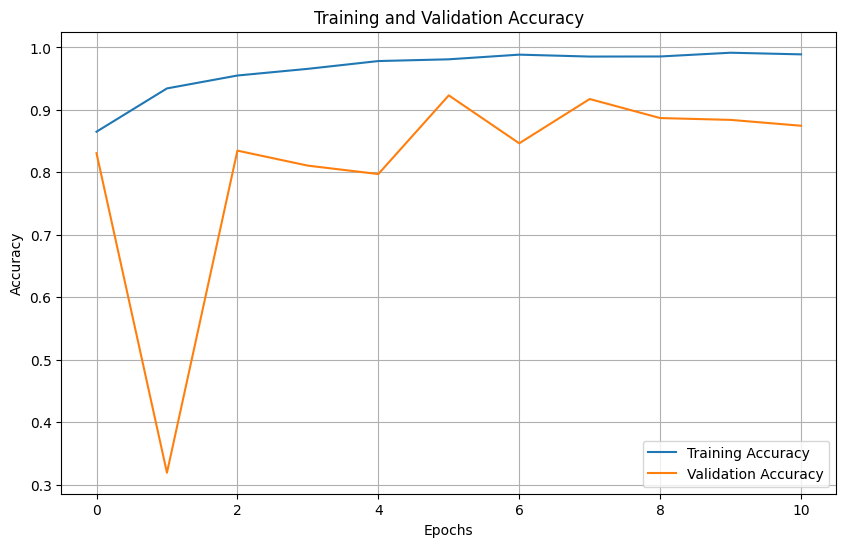

In [11]:
# Visualize Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Save the Final Model
model.save("resnet50_leukemia_final_model.h5")


In [12]:
def plot_training(hist):

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

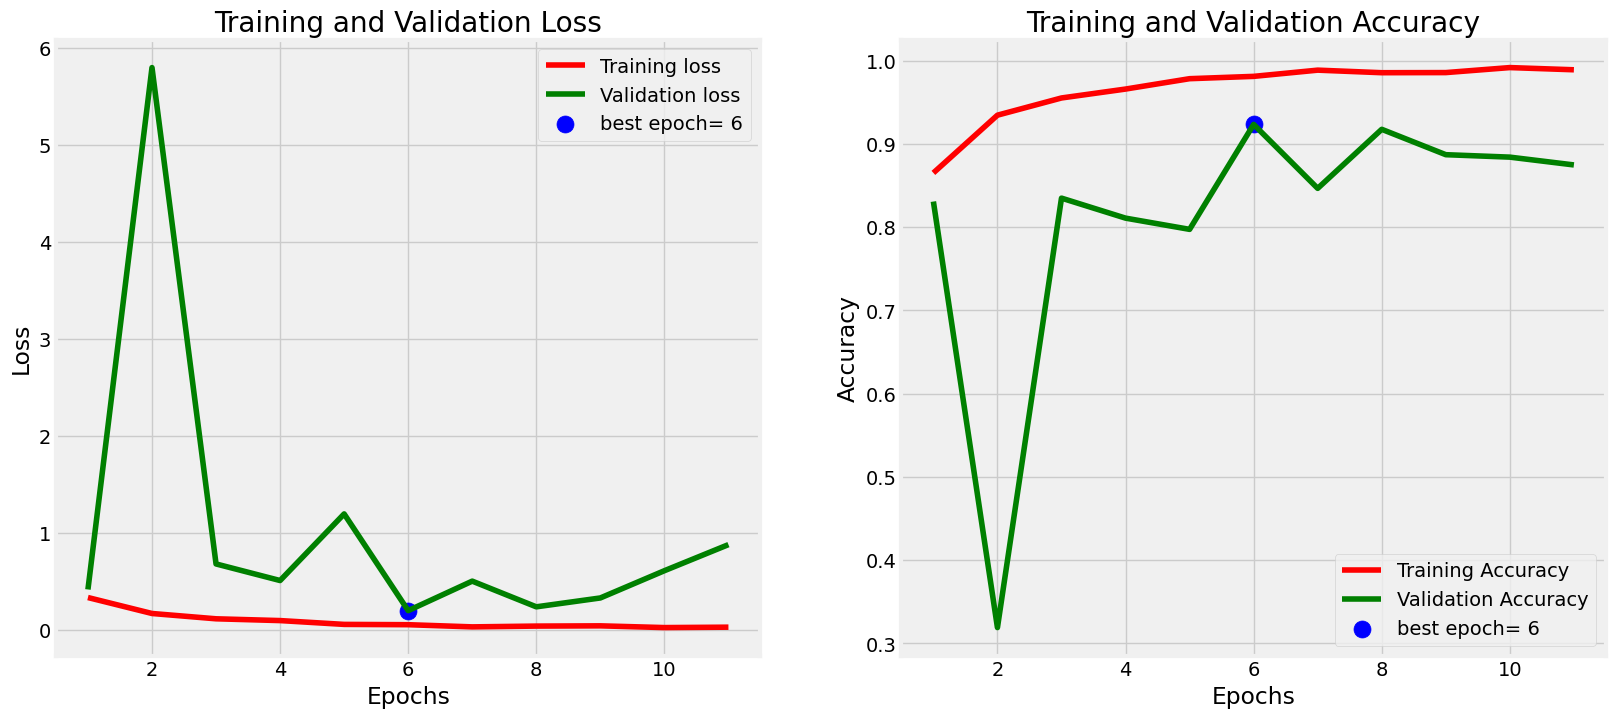

In [13]:
plot_training(history)

67/67 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step
Confusion Matrix (without normalization)
[[ 562  116]
 [  95 1360]]


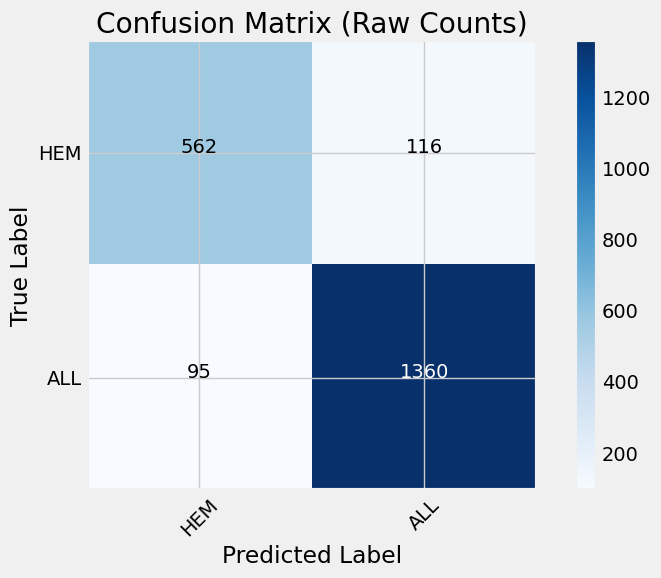

Normalized Confusion Matrix
[[0.82890855 0.17109145]
 [0.0652921  0.9347079 ]]


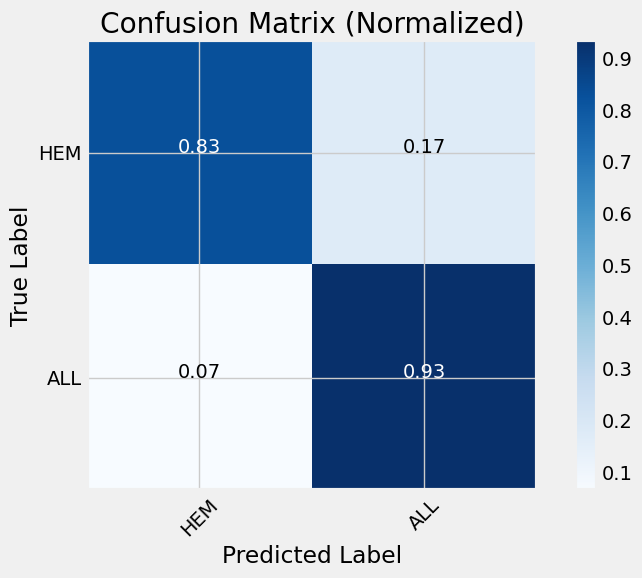

In [15]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predictions and Confusion Matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Define the Plot Function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix (without normalization)")

    print(cm)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot Without Normalization
plot_confusion_matrix(cm, classes=['HEM', 'ALL'], normalize=False, title='Confusion Matrix (Raw Counts)')

# Plot With Normalization
plot_confusion_matrix(cm, classes=['HEM', 'ALL'], normalize=True, title='Confusion Matrix (Normalized)')


67/67 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step


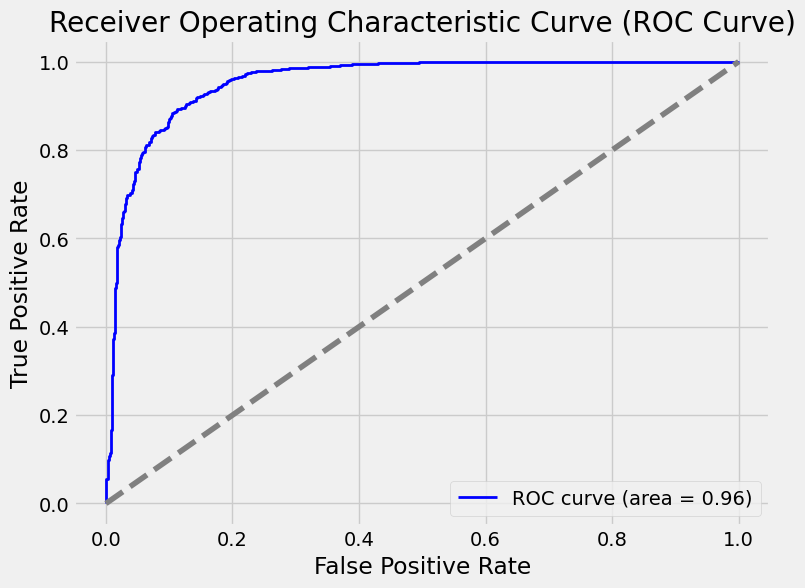

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and model are already defined
# y_test = np.array([0, 1, 0, 1, ...])  # True labels (binary)

# Get predicted probabilities for the positive class (class 1)
y_pred_prob = model.predict(X_test).flatten()  # Flatten the output to get a 1D array

# 1. Compute ROC curve and ROC AUC for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 2. Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (ROC Curve)')
plt.legend(loc="lower right")
plt.show()

Accuracy: 0.9011
Precision: 0.9214
Recall: 0.9347
F1-Score: 0.9280
ROC-AUC: 0.9555
Confusion Matrix:
 [[ 562  116]
 [  95 1360]]


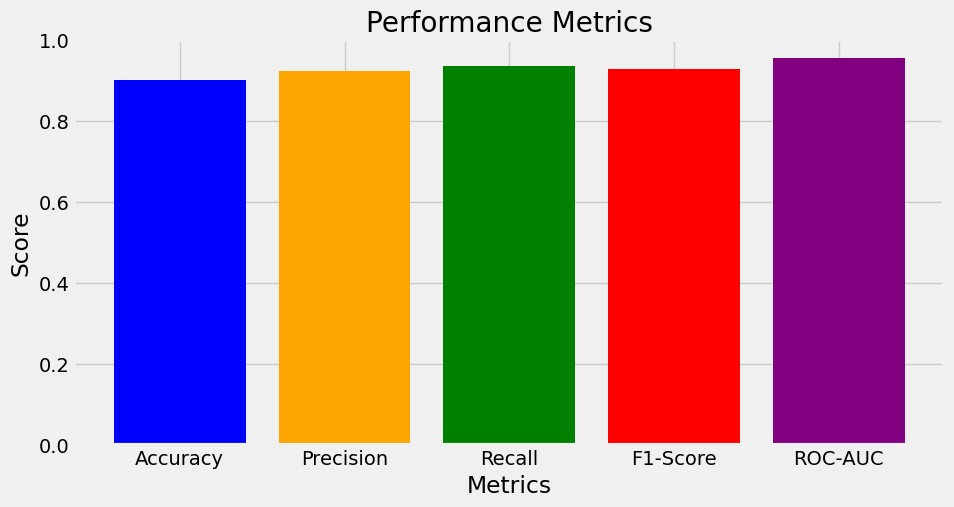

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred, average='binary')  # Adjust for multi-class
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:\n", cm)

# Plotting the performance metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metric_values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 5))
plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.ylim(0, 1)  # Ensure the y-axis ranges from 0 to 1
plt.show()